# Chemical data analysis and visualization (part 3 - WQI)

### Library imports

In [2]:
library(openxlsx)
library(tidyverse)

### 1. Importing the chemical data
Detailed explanation in [chemical_data1.ipynb](chemical_data1.ipynb)

In [3]:
df <- openxlsx::read.xlsx("data/chemical_data.xlsx",sheet=1)
df["sampling.date"] <- openxlsx::convertToDate(df[["sampling.date"]])

### 2. Computing the Water Quality Index (WQI)

In [4]:
# function determining the WQI
fWQI <- function(par,Va,Vi,Si,has.rec = rep(TRUE,length(par)),use.only.rec = FALSE){
    Wi <- rep(NA,length(par))
    names(Wi) <- par
    qi <- rep(NA,length(par))
    names(qi) <- par
    
    for (i in 1:(length(par))){    
       p <- par[[i]]
       if (use.only.rec==TRUE){
         if (has.rec[[p]]==FALSE){
             #print(c(p,has.rec[[p]]))
             next
         }
       }        
       si <-  Si[[p]]
       vi <- Vi[[p]] 
       va <- Va[[p]]
       if (p=="pH"){
         if (va > vi) {  
            si <- si[2]
         } else {
            si <- si[1]
         }        
       } 
        
       Wi[[p]] <- k[[p]]/si   
       qi[[p]] <- 100*(va - vi)/(si - vi)    
    }
    WQI <- sum(Wi*qi,na.rm = TRUE)/sum(Wi,na.rm = TRUE)
    return(WQI)
}

In [5]:
par <- c("pH","F","Cl","NO3","SO4","PO4","Na","K","NH4","Ca2","Mg2","TOC","conductivity") # parameter name
Vi <- c("pH"=7,"F"=0, "Cl"=0,"NO3"=0,"SO4"=0,"PO4"=0,"Na"=0,"K"=0,"NH4"=0,"Ca2"=0,"Mg2"=0, "TOC"=0,"conductivity"=0) # ideal value in water
Si <- list("pH"=c(6.5,8.5),"F"=1.5,"Cl"=250,"NO3"=10,"SO4"=250,"PO4"=0.09,"Na"=200,"K"=30,"NH4"=35,"Ca2"=200,"Mg2"=150, "TOC"=0.03,"conductivity"=2000) # standard parameter value
k <- c("pH"=1,"F"=1, "Cl"=1,"NO3"=1,"SO4"=1,"PO4"=1,"Na"=1,"K"=1,"NH4"=1,"Ca2"=1,"Mg2"=1, "TOC"=1,"conductivity"=1) # proportionality constant
has.rec <- c("pH"=TRUE,"F"=TRUE,"Cl"=TRUE,"NO3"=TRUE,"SO4"=TRUE,"PO4"=FALSE,"Na"=TRUE,"K"=TRUE,"NH4"=TRUE,"Ca2"=TRUE,"Mg2"=TRUE,"TOC"=FALSE,"conductivity"=TRUE)


Va <- rep(NA,length(par))
names(Va) <- par

WQI <- NULL
WQI_all <- NULL

WQI.class <- NULL

for (i in 1:nrow(df)){
    
    for (p in par){
        Va[[p]] <- df[[i,p]]
    }
    
    wqi <- fWQI(par,Va,Vi,Si,has.rec,use.only.rec = TRUE)
    WQI <- c(WQI,wqi)
    
    wqi.class <- NA
    if (wqi < 26) { 
        wqi.class <- "Excellent" 
    } else if (wqi < 51) {
        wqi.class <- "Good" 
    }  else if (wqi < 76) {
        wqi.class <- "Poor" 
    } else if (wqi < 100) {
        wqi.class <- "Very poor" 
    } else {
        wqi.class <- "Unsuitable"
    }
    
    WQI.class <- c(WQI.class,wqi.class)
   # WQI_all <- c(WQI_all,fWQI(par,Va,Vi,Si,has.rec,use.only.rec = FALSE))
}

df.WQI <- data.frame(measurement.series = df[['measurement.series']],series = df[['water.source.type.flag']],water.source.type = df[['water.source.type']],WQI,WQI.class)
#openxlsx::write.xlsx(df.WQI,"WQI.xlsx")
head(df.WQI)

,measurement.series,series,water.source.type,WQI,WQI.class
,<chr>,<chr>,<chr>,<dbl>,<chr>
1,MAD_A,MAD1,lake,47.43821,Good
2,MAD_A,MAD2,lake,12.64413,Excellent
3,MAD_A,MAD3,lake,13.20005,Excellent
4,MAD_A,MAD4,deep well,11.33364,Excellent
5,MAD_A,MAD5,river,174.03041,Unsuitable
6,MAD_A,MAD6,deep well,18.85272,Excellent


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


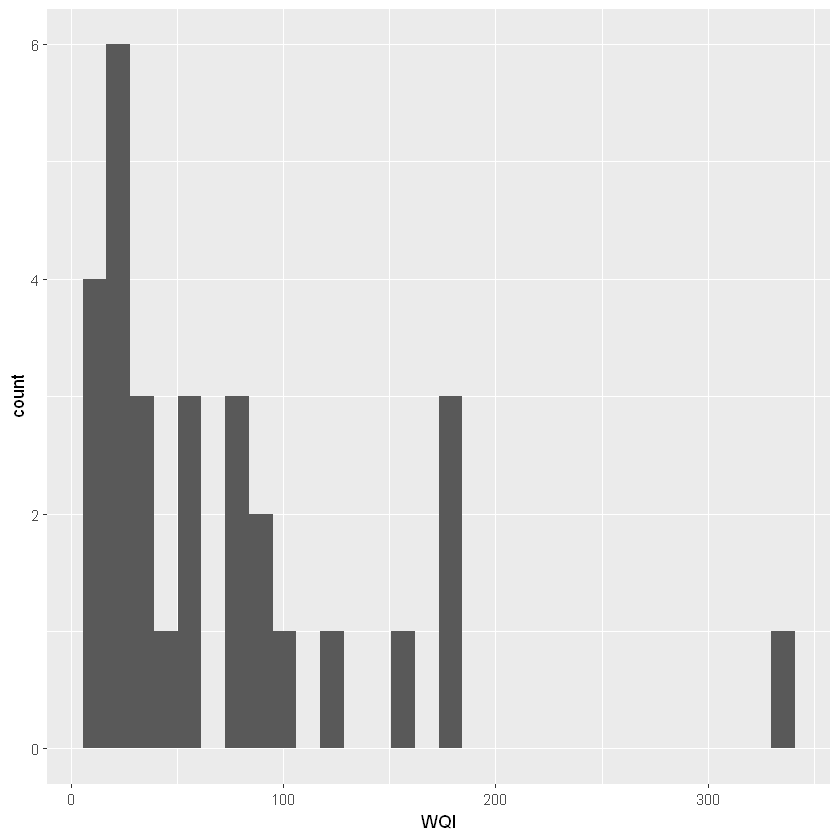

In [6]:
ggplot(df.WQI,aes(x=WQI)) + geom_histogram()

In [7]:
shapiro.test(df.WQI$WQI)


	Shapiro-Wilk normality test

data:  df.WQI$WQI
W = 0.78495, p-value = 4.54e-05


measurement.series,mean,se
<chr>,<dbl>,<dbl>
MAD_A,46.24986,26.153816
MAD_B,121.83797,27.513187
RWA,46.98417,7.846436
UGA,43.09336,9.696218


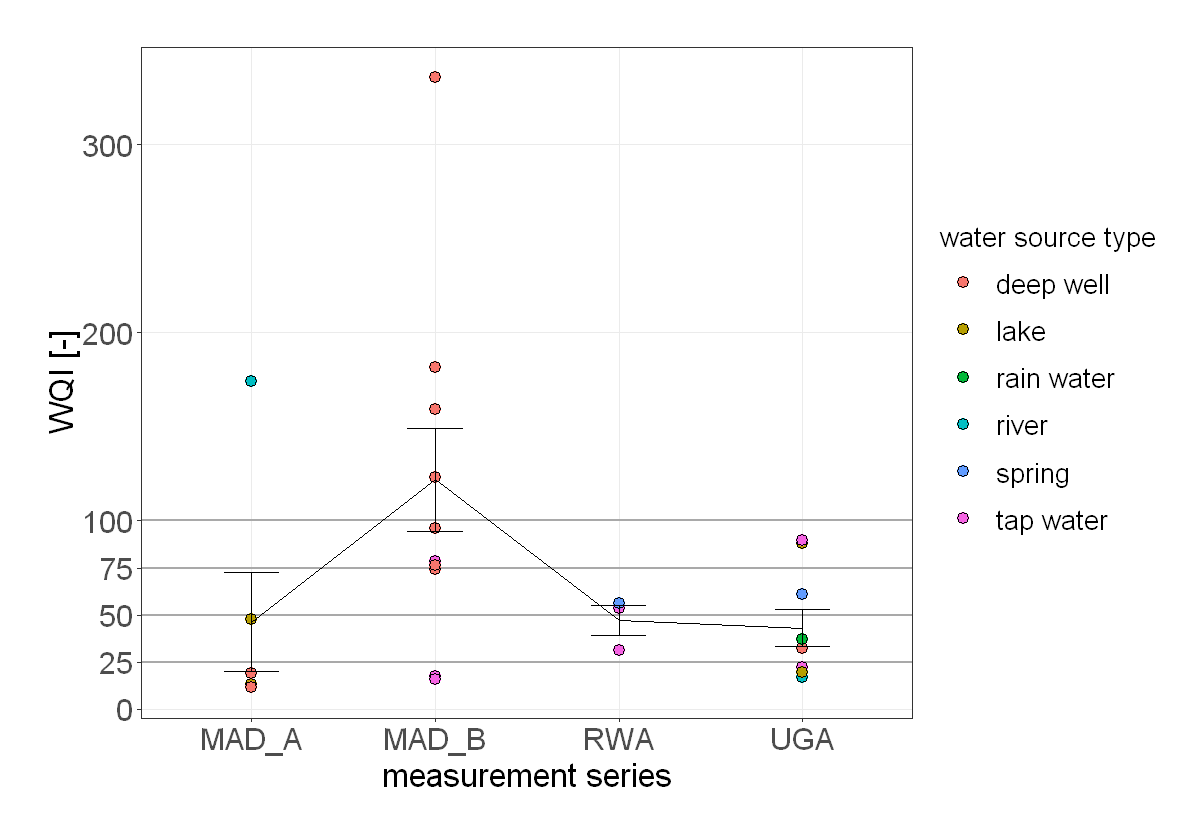

In [8]:
tmp.dfWQI <- df.WQI %>% group_by(measurement.series) %>% summarize(mean=mean(WQI),se=(function(x) {return(sd(x)/sqrt(length(x)))})(WQI))
tmp.dfWQI

options(repr.plot.height=7,repr.plot.width=10)
ggplot(tmp.dfWQI) + 
             geom_hline(yintercept = 25,color="darkgray",linewidth=0.75) +
             geom_hline(yintercept = 50,color="darkgray",linewidth=0.75) +
             geom_hline(yintercept = 75,color="darkgray",linewidth=0.75) +
             geom_hline(yintercept = 100,color="darkgray",linewidth=0.75) +

             geom_point(data=df.WQI,aes(x=measurement.series,y=WQI,fill=water.source.type),size=3,shape=21) + 
             geom_path(aes(x=measurement.series,y=mean,group=1))+
             geom_errorbar(aes(x=measurement.series,ymin=mean-se, ymax=mean+se), width=.3)+
             guides(fill=guide_legend(title="water source type"))+
             xlab("measurement series") + ylab("WQI [-]") + 

scale_y_continuous(breaks=c(0,25,50,75,100,200,300)) +

theme_bw() + theme(axis.text.x = element_text(size=18), panel.grid.minor = element_blank(),
                   axis.text.y = element_text(size=18),
                   axis.title = element_text(size=20),
                #   legend.position="none",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                   legend.title = element_text(size=16), #change legend title font size
                   legend.text = element_text(size=16),
                  plot.margin = unit(c(1,1,1,1), "cm")) 


#ggsave(paste0(img.path,"WQI_mean_plot.tiff"),height=7,width=10,dpi=600,compression="lzw",bg="white")
#ggsave(paste0(img.path,"WQI_mean_plot.png"),height=7,width=10,dpi=150,bg="white")

In [9]:
kruskal.test(WQI ~ measurement.series, data = df.WQI)


	Kruskal-Wallis rank sum test

data:  WQI by measurement.series
Kruskal-Wallis chi-squared = 7.9032, df = 3, p-value = 0.04805


In [10]:
pairwise.wilcox.test(df.WQI$WQI, df.WQI$measurement.series,p.adjust.method = "BH")


	Pairwise comparisons using Wilcoxon rank sum exact test 

data:  df.WQI$WQI and df.WQI$measurement.series 

      MAD_A MAD_B RWA 
MAD_B 0.14  -     -   
RWA   0.31  0.25  -   
UGA   0.31  0.14  0.73

P value adjustment method: BH 

water.source.type,mean,se
<chr>,<dbl>,<dbl>
deep well,109.39202,27.278761
lake,36.07008,14.429513
rain water,36.98095,NA
river,95.41050,78.619914
spring,58.35021,2.331888
tap water,44.13609,11.443039


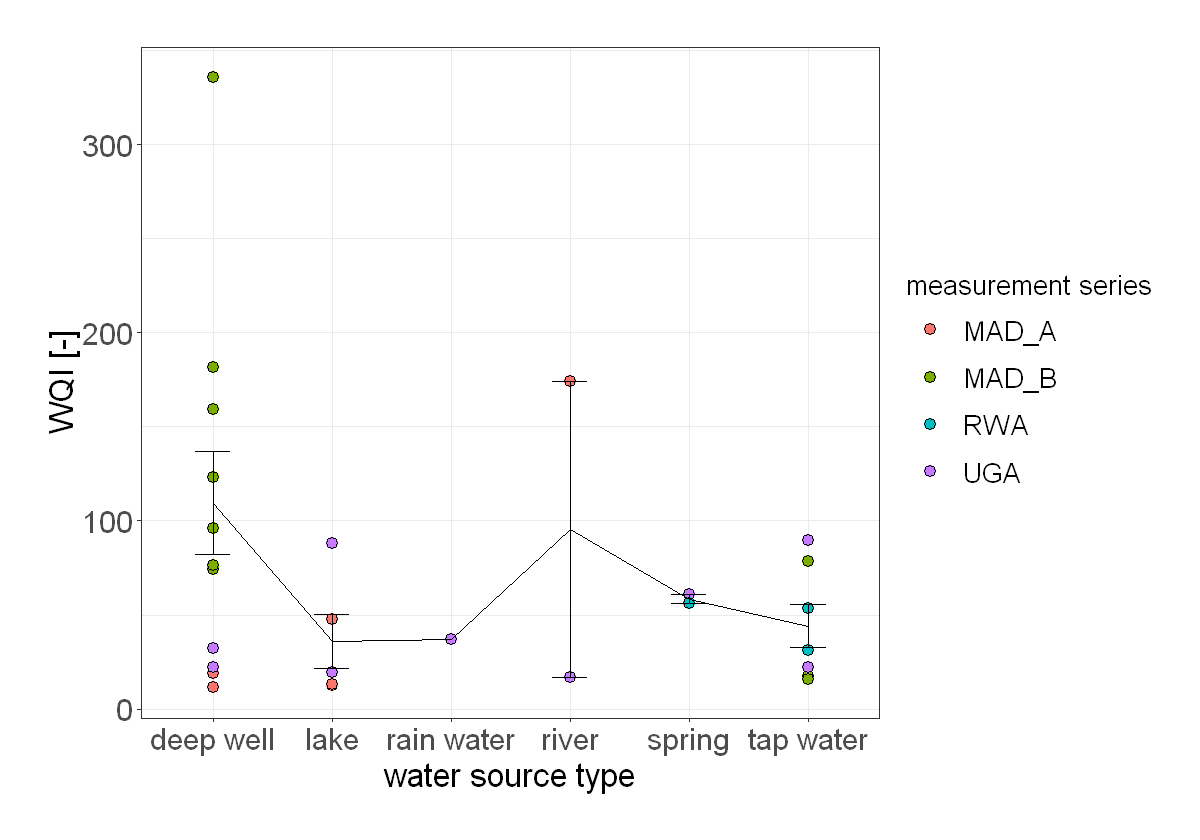

In [11]:
tmp.dfWQI <- df.WQI %>% group_by(water.source.type) %>% summarize(mean=mean(WQI),se=(function(x) {return(sd(x)/sqrt(length(x)))})(WQI))
tmp.dfWQI

options(repr.plot.height=7,repr.plot.width=10)
ggplot(tmp.dfWQI) + 
             geom_point(data=df.WQI,aes(x=water.source.type,y=WQI,fill=measurement.series),size=3,shape=21) + 
             geom_path(aes(x=water.source.type,y=mean,group=1))+
             geom_errorbar(aes(x=water.source.type,ymin=mean-se, ymax=mean+se), width=.3)+

             guides(fill=guide_legend(title="measurement series"))+
             xlab("water source type") + ylab("WQI [-]") + 
theme_bw() + theme(axis.text.x = element_text(size=18),
                   axis.text.y = element_text(size=18),
                   axis.title = element_text(size=20),
                #   legend.position="none",
                   legend.key.size = unit(2, 'cm'), #change legend key size
                   legend.key.height = unit(1, 'cm'), #change legend key height
                   legend.key.width = unit(1, 'cm'), #change legend key width
                   legend.title = element_text(size=16), #change legend title font size
                   legend.text = element_text(size=16),
                  plot.margin = unit(c(1,1,1,1), "cm")) 

In [12]:
kruskal.test(WQI ~ water.source.type, data = df.WQI)


	Kruskal-Wallis rank sum test

data:  WQI by water.source.type
Kruskal-Wallis chi-squared = 4.7322, df = 5, p-value = 0.4494


In [13]:
pairwise.wilcox.test(df.WQI$WQI, df.WQI$water.source.type,p.adjust.method = "BH")


	Pairwise comparisons using Wilcoxon rank sum exact test 

data:  df.WQI$WQI and df.WQI$water.source.type 

           deep well lake rain water river spring
lake       1         -    -          -     -     
rain water 1         1    -          -     -     
river      1         1    1          -     -     
spring     1         1    1          1     -     
tap water  1         1    1          1     1     

P value adjustment method: BH 